In [169]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [170]:
num_cities = 5

In [ ]:
rng = np.random.default_rng(42)
population = rng.lognormal(mean=11.5, sigma=1.5, size=num_cities).astype(int)
print(population)
total_population = population.sum()
print(f"{total_population=}")

[155916  20744 304271 404678   5289]
total_population=8.91e+05


In [189]:
per_person_demand = rng.lognormal(mean=0.25, sigma=0.4, size=num_cities)
per_person_demand

array([0.76271427, 1.35139334, 1.13145336, 1.2754251 , 0.91281909])

In [ ]:
demand = population * per_person_demand
total_demand = demand.sum()
print(f"{total_demand=:.2f}")

total_demand=1012185.49


In [181]:
elasticity = rng.normal(-0.5, 0.3, size=100)
elasticity = elasticity[(-3 < elasticity) & (elasticity < 0)][:num_cities]
elasticity

array([-0.23618061, -0.26666242, -0.48019079, -0.16182764, -0.3597472 ])

In [ ]:
A = per_person_demand * np.exp(-elasticity)
A

array([0.96590365, 1.76437864, 1.8288617 , 1.4994632 , 1.30803973])

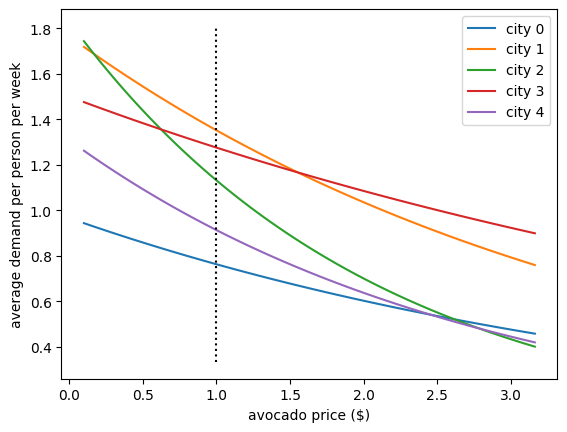

In [ ]:
p = np.logspace(-1, 0.5, 100)
qs = [A[i] * np.exp(elasticity[i] * p) for i in range(num_cities)]
for i in range(num_cities):
    plt.plot(p, qs[i], label=f"city {i}")
plt.vlines(1, *plt.ylim(), colors="k", linestyles=":")
plt.legend()
plt.xlabel("avocado price ($)")
plt.ylabel("average demand per person per week")
plt.show()

In [259]:
# price = rng.lognormal(0.5, 0.2, size=10000)
# price = price[(0.8 < price) & (price < 4)]
# plt.hist(price)

In [464]:
average_price = 1.5

average_price_demand = np.sum(A * np.exp(elasticity * average_price) * population)
average_supply = 1.1 * np.round(average_price_demand / 1e5) * 1e5
average_supply

np.float64(990000.0)

In [465]:
num_weeks = 52

supply = rng.normal(average_supply, 0.2 * average_supply, size=num_weeks).round()
supply

array([ 785398., 1194917.,  923497.,  917492.,  910668.,  943881.,
        910293.,  914017., 1154909.,  845443.,  973006., 1158973.,
        862396.,  775959., 1054169.,  994125.,  766114.,  847181.,
       1373914., 1097490., 1223691., 1009366., 1046351.,  972603.,
        902395.,  861390.,  900033., 1255080., 1047678.,  708297.,
       1193852.,  940460.,  791540.,  807359.,  964581.,  859431.,
        552415.,  783113., 1194092.,  935714.,  922281.,  684233.,
        819303., 1194240., 1224479., 1146078., 1133155.,  947215.,
       1058638.,  813959.,  789383.,  950727.])

In [466]:
price = (
    average_price + 0.2 * (average_supply - supply) / (0.2 * average_supply)
).round(2)
price

array([1.71, 1.29, 1.57, 1.57, 1.58, 1.55, 1.58, 1.58, 1.33, 1.65, 1.52,
       1.33, 1.63, 1.72, 1.44, 1.5 , 1.73, 1.64, 1.11, 1.39, 1.26, 1.48,
       1.44, 1.52, 1.59, 1.63, 1.59, 1.23, 1.44, 1.78, 1.29, 1.55, 1.7 ,
       1.68, 1.53, 1.63, 1.94, 1.71, 1.29, 1.55, 1.57, 1.81, 1.67, 1.29,
       1.26, 1.34, 1.36, 1.54, 1.43, 1.68, 1.7 , 1.54])

In [502]:
data = {"week": [], "city": [], "supply": [], "price": []}
for w in range(num_weeks):
    for c in range(num_cities):
        data["week"].append(w)
        data["city"].append(c)
        data["supply"].append(np.round(supply[w] * population[c] / total_population))
        data["price"].append(price[w])

df = pd.DataFrame(data)
df["supply"] = df["supply"].astype(int)

city_df = pd.DataFrame({"A": A, "elasticity": elasticity, "population": population})
df = df.merge(city_df, how="left", left_on="city", right_index=True)

assert np.allclose(supply, df.groupby("week").sum()["supply"])
assert np.allclose(df.groupby("week").mean()["price"], price)


df["price"] = (df["price"] * (1 + 0.05 * rng.normal(size=len(df)))).round(2)

df["demand"] = (
    (df["population"] * df["A"] * np.exp(df["elasticity"] * df["price"]))
    * (1 + 0.05 * rng.normal(size=len(df)))
).astype(int)

df["sold"] = np.minimum(df["supply"], df["demand"])
df["sold_out"] = df["supply"] == df["sold"]
df["waste"] = df["supply"] - df["sold"]

df

,week,city,supply,price,A,elasticity,population,demand,sold,sold_out,waste
0,0,0,137452,1.66,0.965904,-0.236181,155916,99886,99886,False,37566
1,0,1,18287,1.58,1.764379,-0.266662,20744,24427,18287,True,0
2,0,2,268239,1.65,1.828862,-0.480191,304271,254814,254814,False,13425
3,0,3,356756,1.94,1.499463,-0.161828,404678,443257,356756,True,0
4,0,4,4663,1.71,1.308040,-0.359747,5289,3777,3777,False,886
...,...,...,...,...,...,...,...,...,...,...,...
255,51,0,166387,1.57,0.965904,-0.236181,155916,107969,107969,False,58418
256,51,1,22137,1.56,1.764379,-0.266662,20744,26195,22137,True,0
257,51,2,324705,1.50,1.828862,-0.480191,304271,264973,264973,False,59732
258,51,3,431854,1.57,1.499463,-0.161828,404678,458223,431854,True,0


In [503]:
df["sold_out"].sum()

np.int64(84)

(array([99.,  9., 18., 22., 30., 19., 30., 15., 11.,  7.]),
 array([0.        , 0.05269433, 0.10538867, 0.158083  , 0.21077734,
        0.26347167, 0.31616601, 0.36886034, 0.42155467, 0.47424901,
        0.52694334]),
 <BarContainer object of 10 artists>)

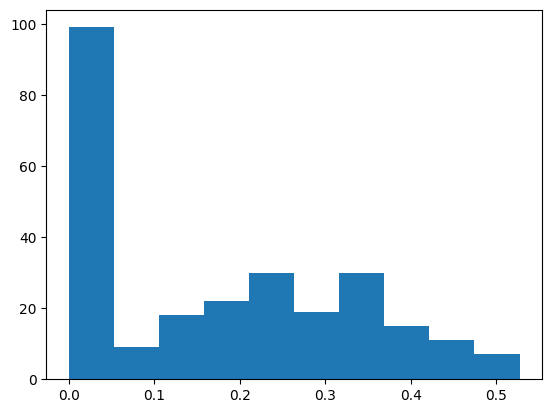

In [504]:
plt.hist((df["waste"] / df["supply"]))

In [505]:
df[["city", "supply", "price", "sold"]]

,city,supply,price,sold
0,0,137452,1.66,99886
1,1,18287,1.58,18287
2,2,268239,1.65,254814
3,3,356756,1.94,356756
4,4,4663,1.71,3777
...,...,...,...,...
255,0,166387,1.57,107969
256,1,22137,1.56,22137
257,2,324705,1.50,264973
258,3,431854,1.57,431854


<Axes: xlabel='price', ylabel='sold_per_person'>

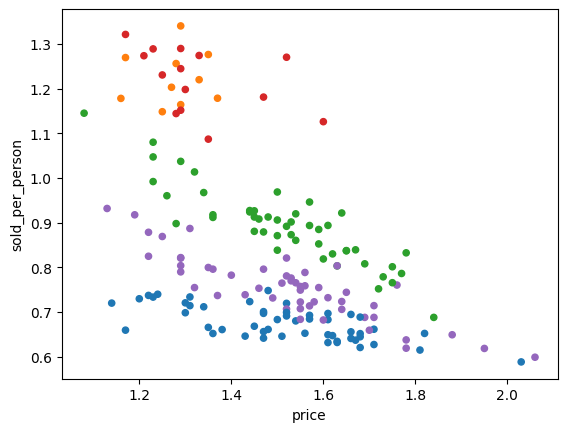

In [506]:
df["sold_per_person"] = df["sold"] / df["population"]
s = pd.Series(["C0", "C1", "C2", "C3", "C4"])
df[~df["sold_out"]].plot.scatter(
    "price",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)

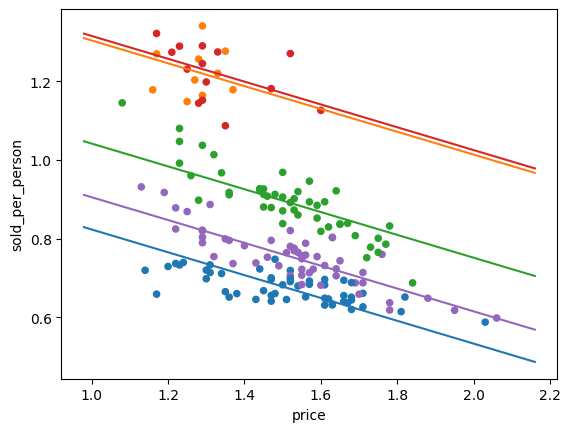

In [572]:
from sklearn.linear_model import LinearRegression

mask = ~df["sold_out"]
X = pd.concat(
    [pd.get_dummies(df.loc[mask, "city"], prefix="city"), df.loc[mask, "price"]], axis=1
)
y = df.loc[mask, "sold_per_person"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

min_price = df["price"].min()
max_price = df["price"].max()

df[~df["sold_out"]].plot.scatter(
    "price",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)

for c in range(num_cities):
    XX = X[:0].copy()
    XX.loc[:] = np.zeros((2, 6))
    XX[f"city_{c}"] = 1
    XX["price"] = [min_price - 0.1, max_price + 0.1]
    yy = model.predict(XX)
    plt.plot(XX["price"], yy, f"C{c}")

In [574]:
model.coef_

array([ 1.11359926,  1.59381113,  1.33187261,  1.60528884,  1.19556141,
       -0.29009098])

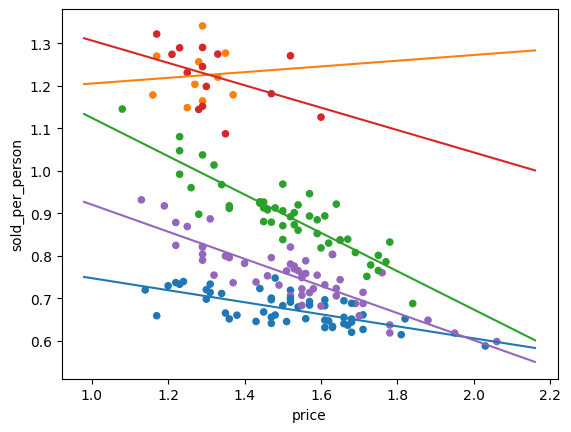

In [ ]:
mask = ~df["sold_out"]
X = pd.concat(
    [
        pd.get_dummies(df.loc[mask, "city"], prefix="city"),
        pd.get_dummies(df.loc[mask, "city"], prefix="price_city"),
    ],
    axis=1,
)
for c in range(num_cities):
    X[f"price_city_{c}"] *= df.loc[mask, "price"]

y = df.loc[mask, "sold_per_person"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

min_price = df["price"].min()
max_price = df["price"].max()

df[~df["sold_out"]].plot.scatter(
    "price",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)


for c in range(num_cities):
    XX = X[:0].copy()
    XX.loc[:] = np.zeros((2, 10))
    XX[f"city_{c}"] = 1
    XX[f"price_city_{c}"] = p
    yy = model.predict(XX)
    plt.plot(XX[f"price_city_{c}"], yy, f"C{c}")

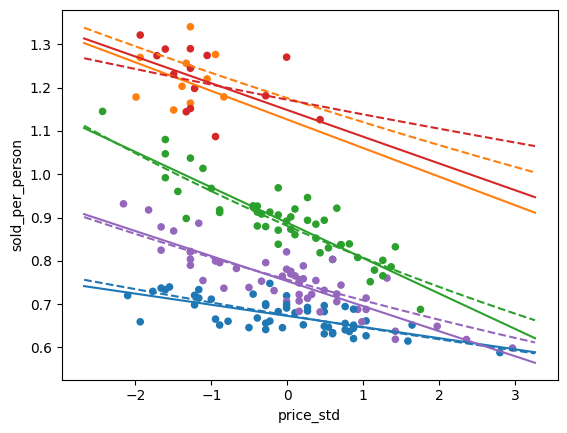

In [ ]:
from sklearn.linear_model import Ridge

df["price_std"] = (df["price"] - df["price"].mean()) / df["price"].std()


mask = ~df["sold_out"]
X = pd.concat(
    [
        pd.get_dummies(df.loc[mask, "city"], prefix="city"),
        pd.get_dummies(df.loc[mask, "city"], prefix="price_std_city"),
    ],
    axis=1,
)
for c in range(num_cities):
    X[f"price_std_city_{c}"] *= df.loc[mask, "price_std"]

y = df.loc[mask, "sold_per_person"]

model = Ridge(fit_intercept=False, alpha=0.07)
model.fit(X, y)

df[~df["sold_out"]].plot.scatter(
    "price_std",
    "sold_per_person",
    c=df.loc[~df["sold_out"], "city"].apply(lambda c: f"C{c}"),  # type: ignore
)

p = np.linspace(df["price_std"].min() * 1.1, df["price_std"].max() * 1.1, 100)
pp = p * df["price"].std() + df["price"].mean()

for c in range(num_cities):
    XX = X[:0].copy()
    XX.loc[:] = np.zeros((2, 10))
    XX[f"city_{c}"] = 1
    XX[f"price_std_city_{c}"] = [p[0], p[-1]]
    yy = model.predict(XX)
    plt.plot(XX[f"price_std_city_{c}"], yy, f"C{c}")
    plt.plot(p, A[c] * np.exp(elasticity[c] * pp), f"--C{c}", label=f"city {i}")

In [ ]:
np.sum(df["sold"] * df["price"])

np.float64(64972015.089999996)